## 1

In [4]:
import warnings
warnings.filterwarnings('ignore')
!pip install scikit-plot
!pip install wordcloud
!pip install textblob  

import pandas as pd
import numpy as np
import scipy
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer 
from nltk.stem import PorterStemmer, LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore') 

from IPython.display import Image

%matplotlib inline

  Using cached textblob-0.17.1-py2.py3-none-any.whl (636 kB)


In [5]:
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv", index_col=0)
print(df.shape)
df.head(3)

(23486, 10)


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses


In [6]:
df.groupby(['Rating', 'Recommended IND'])['Recommended IND'].count()

Rating  Recommended IND
1       0                    826
        1                     16
2       0                   1471
        1                     94
3       0                   1682
        1                   1189
4       0                    168
        1                   4909
5       0                     25
        1                  13106
Name: Recommended IND, dtype: int64

In [7]:
df.loc[(df.Rating==5) & (df['Recommended IND']==0)]['Review Text'].iloc[1]

"This top is one of my retailer faves! it is so comfortable and love the quality and design. i receive many compliments on this top. i usually wear an xs or s in retailer tops and the xs was a little tight in the arms. the dressing room attendant suggested ordering a petite small so i wouldn't lose the shape. so glad i did. it fits perfect! i even ordered when it was on sale!! the gray color is perfect! its not too thick or thin."

In [8]:
text_df = df[['Title', 'Review Text', 'Recommended IND']]
text_df.head()

,Title,Review Text,Recommended IND
0,NaN,Absolutely wonderful - silky and sexy and comf...,1
1,NaN,Love this dress! it's sooo pretty. i happene...,1
2,Some major design flaws,I had such high hopes for this dress and reall...,0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1
4,Flattering shirt,This shirt is very flattering to all due to th...,1


In [9]:
text_df['Review'] = text_df['Title'] + ' ' + text_df['Review Text']
text_df = text_df.drop(labels=['Title','Review Text'] , axis=1)
text_df.head()

,Recommended IND,Review
0,1,NaN
1,1,NaN
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...


In [10]:
text_df.Review.isna().sum()

3811

In [11]:
text_df = text_df[~text_df.Review.isna()]
text_df = text_df.rename(columns={"Recommended IND": "Recommended"})
print("My data's shape is:", text_df.shape)
text_df.head()

My data's shape is: (19675, 2)


,Recommended,Review
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...
5,0,Not for the very petite I love tracy reese dre...
6,1,Cagrcoal shimmer fun I aded this in my basket ...


In [12]:
text_df['Recommended'].unique()

array([0, 1], dtype=int64)

In [13]:
text_df['Recommended'].value_counts(normalize=True)

1    0.818297
0    0.181703
Name: Recommended, dtype: float64

In [14]:
text_df['Review_length'] = text_df['Review'].apply(len)
print(text_df.shape)
text_df.head()

(19675, 3)


,Recommended,Review,Review_length
2,0,Some major design flaws I had such high hopes ...,524
3,1,"My favorite buy! I love, love, love this jumps...",141
4,1,Flattering shirt This shirt is very flattering...,209
5,0,Not for the very petite I love tracy reese dre...,512
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517


In [15]:
text_df['Review_length'].describe()

count    19675.000000
mean       338.450267
std        144.740126
min         23.000000
25%        217.000000
50%        336.000000
75%        496.000000
max        557.000000
Name: Review_length, dtype: float64

<AxesSubplot:xlabel='Review_length', ylabel='Density'>

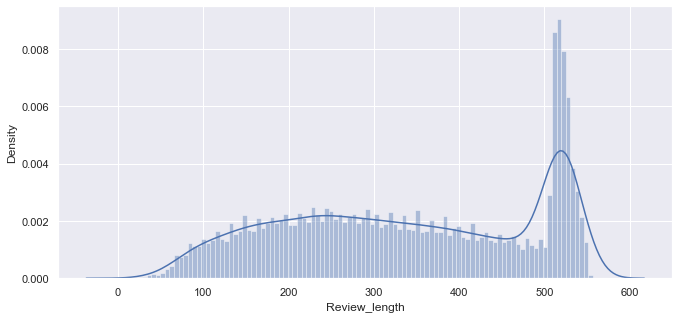

In [16]:
sns.set(rc={'figure.figsize':(11,5)})
sns.distplot(text_df['Review_length'] ,hist=True, bins=100)

In [17]:
df_zero = text_df[text_df['Recommended']==0]
df_one = text_df[text_df['Recommended']==1]

<AxesSubplot:ylabel='Density'>

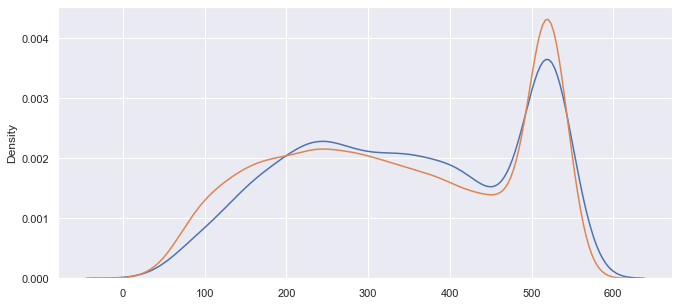

In [18]:
sns.distplot(df_zero[['Review_length']] ,hist=False)
sns.distplot(df_one[['Review_length']], hist=False)

In [19]:
def count_exclamation_mark(string_text):
    count = 0
    for char in string_text:
        if char == '!':
            count += 1
    return count

In [20]:
text_df['count_exc'] = text_df['Review'].apply(count_exclamation_mark)
text_df.head(5)

,Recommended,Review,Review_length,count_exc
2,0,Some major design flaws I had such high hopes ...,524,1
3,1,"My favorite buy! I love, love, love this jumps...",141,3
4,1,Flattering shirt This shirt is very flattering...,209,3
5,0,Not for the very petite I love tracy reese dre...,512,0
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517,0


In [21]:
text_df['count_exc'].describe(np.arange(0.2, 1.0, 0.2))

count    19675.000000
mean         0.883151
std          1.412098
min          0.000000
20%          0.000000
40%          0.000000
50%          0.000000
60%          1.000000
80%          2.000000
max         41.000000
Name: count_exc, dtype: float64

<AxesSubplot:>

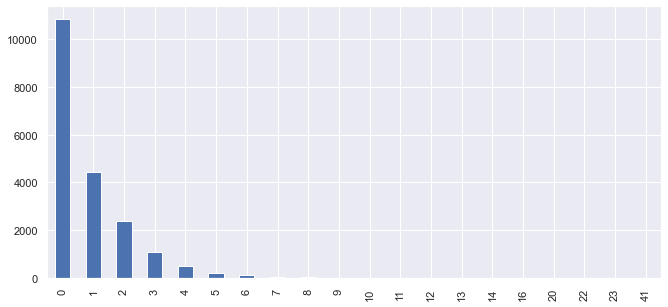

In [22]:
text_df['count_exc'].value_counts().sort_index().plot(kind='bar')

In [23]:
text_df[text_df['count_exc']== 41].index

Int64Index([3301], dtype='int64')

In [24]:
text_df['Review'][3301]

'Beautiful and unique. Love this top, just received it today.\r\nit is a very artistic interpretation for a casual top.\r\nthe blue is gorgeous!\r\nthe unique style of the peplm and the details on the front set this apart!\r\nruns a little shorter, but i feel the length enhances it;s beauty, and is appropriate for the overall design.\r\nlove !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\r\nordered my usual size and it fits perfectly.'

In [25]:
text_df['Polarity'] = text_df['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
text_df.head(5)

,Recommended,Review,Review_length,count_exc,Polarity
2,0,Some major design flaws I had such high hopes ...,524,1,0.073209
3,1,"My favorite buy! I love, love, love this jumps...",141,3,0.560714
4,1,Flattering shirt This shirt is very flattering...,209,3,0.512891
5,0,Not for the very petite I love tracy reese dre...,512,0,0.181111
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517,0,0.157500


<AxesSubplot:ylabel='Frequency'>

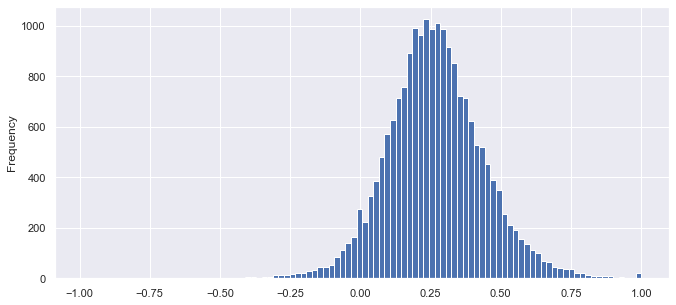

In [26]:
text_df['Polarity'].plot(kind='hist', bins=100)

In [27]:
text_prep = text_df.copy()

In [28]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [29]:
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

In [30]:
text_prep['Review'] = text_prep['Review'].apply(punctuation_removal)
text_prep['Review'].head()

2    Some major design flaws I had such high hopes ...
3    My favorite buy I love love love this jumpsuit...
4    Flattering shirt This shirt is very flattering...
5    Not for the very petite I love tracy reese dre...
6    Cagrcoal shimmer fun I aded this in my basket ...
Name: Review, dtype: object

In [31]:
Image(url= "http://josecarilloforum.com/imgs/longnounphrase_schematic-1B.png", width=600, height=10)

In [32]:
def adj_collector(review_string):
    new_string=[]
    review_string = word_tokenize(review_string)
    tup_word = nltk.pos_tag(review_string)
    for tup in tup_word:
        if 'VB' in tup[1] or tup[1]=='JJ':  #Verbs and Adjectives
            new_string.append(tup[0])  
    return ' '.join(new_string)

In [35]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

text_prep['Review'] = text_prep['Review'].apply(adj_collector)
text_prep['Review'].head(7)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\glori\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\glori\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


2    major had such high wanted work i ordered smal...
3         favorite love love fabulous wear i get great
4    Flattering is flattering due adjustable is per...
5    petite love reese is petite am tall wear was i...
6    aded last see look i went am pale is gorgeous ...
7    goes ordered had try used top pair went is nic...
8    Flattering love get runs little ordered flatte...
Name: Review, dtype: object

In [37]:
nltk.download('stopwords')
print(stopwords.words('english')[::12])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\glori\AppData\Roaming\nltk_data...


['i', "you'd", 'hers', 'which', 'were', 'a', 'at', 'above', 'again', 'both', 'own', "don't", 'aren', 'haven', "shan't"]


[nltk_data]   Unzipping corpora\stopwords.zip.


In [38]:
stop = stopwords.words('english')
stop.append("i'm")

In [39]:
stop_words = []

for item in stop: 
    new_item = punctuation_removal(item)
    stop_words.append(new_item) 
print(stop_words[::12])

['i', 'youd', 'hers', 'which', 'were', 'a', 'at', 'above', 'again', 'both', 'own', 'dont', 'aren', 'haven', 'shant']


In [40]:
clothes_list =['dress', 'top','sweater','shirt',
               'skirt','material', 'white', 'black',
              'jeans', 'fabric', 'color','order', 'wear']

In [41]:
def stopwords_removal(messy_str):
    messy_str = word_tokenize(messy_str)
    return [word.lower() for word in messy_str 
            if word.lower() not in stop_words and word.lower() not in clothes_list ]

In [42]:
text_prep['Review'] = text_prep['Review'].apply(stopwords_removal)
text_prep['Review'].head()

2    [major, high, wanted, work, ordered, small, us...
3         [favorite, love, love, fabulous, get, great]
4    [flattering, flattering, due, adjustable, perf...
5    [petite, love, reese, petite, tall, long, full...
6    [aded, last, see, look, went, pale, gorgeous, ...
Name: Review, dtype: object

In [43]:
print(text_prep['Review'][3301])

#'Beautiful and unique. Love this top, just received it today.
# \nit is a very artistic interpretation for a casual top.
# \nthe blue is gorgeous!
# \nthe unique style of the peplm and the details on the front set this apart!
# \nruns a little shorter, but i feel the length enhances it;s beauty, and is appropriate for the overall design.
# \nlove !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\nordered my usual size and it fits perfectly.'

['unique', 'received', 'artistic', 'casual', 'gorgeous', 'unique', 'runs', 'little', 'feel', 'enhances', 'appropriate', 'overall', 'ordered', 'usual', 'fits']


In [44]:
print(text_prep['Review'][267]) 

['nice', 'short', 'tall', 'iamp39d', 'say', 'fits', 'true', 'short', 'iamp39m', 'tall', 'wish', 'came']


In [45]:
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)

In [46]:
text_prep['Review'] = text_prep['Review'].apply(drop_numbers)
text_prep['Review'].head()

2    major high wanted work ordered small usual fou...
3                favorite love love fabulous get great
4    flattering flattering due adjustable perfect p...
5    petite love reese petite tall long full overwh...
6    aded last see look went pale gorgeous turns ma...
Name: Review, dtype: object

In [47]:
print(text_prep['Review'][267]) 

nice short tall say fits true short tall wish came


In [48]:
print(text_prep['Review'][2293])

flattering purchased return expected fit said lbs got get disappointed soft purchase regular fit looked terrible say tall thin yes short petite


In [49]:
porter = PorterStemmer()

In [50]:
text_prep['Review'] = text_prep['Review'].apply(lambda x: x.split())
text_prep['Review'].head()

2    [major, high, wanted, work, ordered, small, us...
3         [favorite, love, love, fabulous, get, great]
4    [flattering, flattering, due, adjustable, perf...
5    [petite, love, reese, petite, tall, long, full...
6    [aded, last, see, look, went, pale, gorgeous, ...
Name: Review, dtype: object

In [51]:
def stem_update(text_list):
    text_list_new = []
    for word in text_list:
        word = porter.stem(word)
        text_list_new.append(word) 
    return text_list_new

In [52]:
text_prep['Review'] = text_prep['Review'].apply(stem_update)
text_prep['Review'].head()

2    [major, high, want, work, order, small, usual,...
3             [favorit, love, love, fabul, get, great]
4    [flatter, flatter, due, adjust, perfect, pair,...
5    [petit, love, rees, petit, tall, long, full, o...
6    [ade, last, see, look, went, pale, gorgeou, tu...
Name: Review, dtype: object

In [53]:
text_prep['Review'] = text_prep['Review'].apply(lambda x: ' '.join(x))
text_prep['Review'].head()

2    major high want work order small usual found s...
3                    favorit love love fabul get great
4     flatter flatter due adjust perfect pair cardigan
5    petit love rees petit tall long full overwhelm...
6    ade last see look went pale gorgeou turn mathc...
Name: Review, dtype: object

In [54]:
print(text_prep['Review'][2293])

flatter purchas return expect fit said lb got get disappoint soft purchas regular fit look terribl say tall thin ye short petit


In [55]:
pos_df = text_prep[text_prep.Recommended== 1]
neg_df = text_prep[text_prep.Recommended== 0]
pos_df.head(3)

,Recommended,Review,Review_length,count_exc,Polarity
3,1,favorit love love fabul get great,141,3,0.560714
4,1,flatter flatter due adjust perfect pair cardigan,209,3,0.512891
6,1,ade last see look went pale gorgeou turn mathc...,517,0,0.157500


In [56]:
pos_words =[]
neg_words = []

for review in pos_df.Review:
    pos_words.append(review) 
pos_words = ' '.join(pos_words)
pos_words[:40]

for review in neg_df.Review:
    neg_words.append(review)
neg_words = ' '.join(neg_words)
neg_words[:400]

'major high want work order small usual found small small zip reorder petit ok overal comfort fit bottom tight sever cheap imo major net c petit love rees petit tall long full overwhelm small shorten narrow take love work return look cheap run small run order fit tight cheap pull caus rip disappoint go say go look style side purchas knew larg next imposs second look cheap awkward tight look describ'

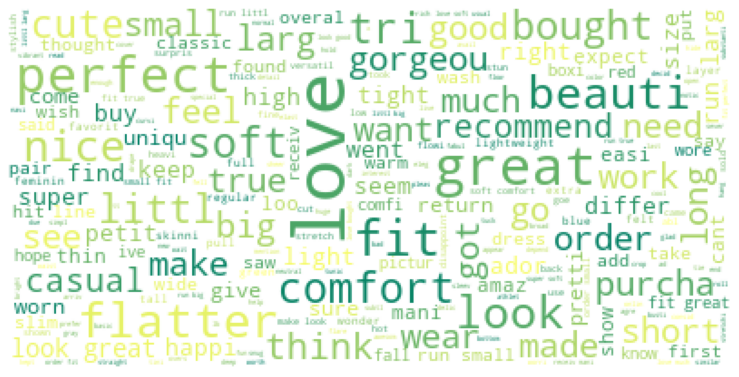

In [57]:
!pip install wordcloud
from wordcloud import WordCloud

wordcloud = WordCloud().generate(pos_words)

wordcloud = WordCloud(background_color="white",max_words=len(pos_words),\
                      max_font_size=40, relative_scaling=.5, colormap='summer').generate(pos_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

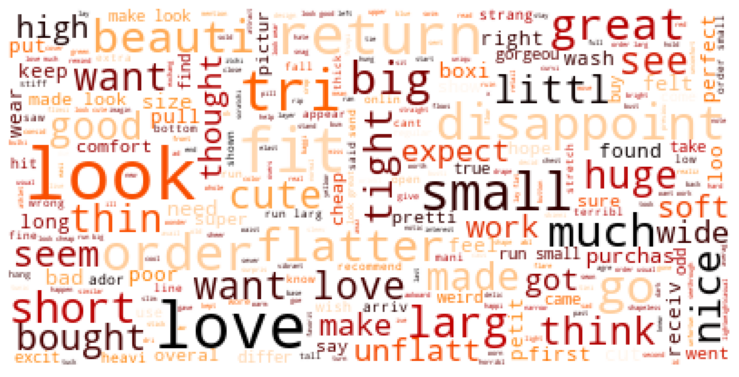

In [58]:
wordcloud = WordCloud().generate(neg_words)

wordcloud = WordCloud(background_color="white",max_words=len(neg_words),\
                      max_font_size=40, relative_scaling=.5, colormap='gist_heat').generate(neg_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [59]:
text_prep['Review'].head()

2    major high want work order small usual found s...
3                    favorit love love fabul get great
4     flatter flatter due adjust perfect pair cardigan
5    petit love rees petit tall long full overwhelm...
6    ade last see look went pale gorgeou turn mathc...
Name: Review, dtype: object

In [60]:
def text_vectorizing_process(sentence_string):
    return [word for word in sentence_string.split()]

In [61]:
bow_transformer = CountVectorizer(text_vectorizing_process)

In [62]:
bow_transformer.fit(text_prep['Review'])

CountVectorizer(input=<function text_vectorizing_process at 0x000001DB774D8310>)

In [63]:
print(text_prep['Review'].iloc[3])

petit love rees petit tall long full overwhelm small shorten narrow take love work return


In [64]:
example = bow_transformer.transform([text_prep['Review'].iloc[3]])
print(example)
#3507=Love
#4438=petit

  (0, 2416)	1
  (0, 3438)	1
  (0, 3507)	2
  (0, 3881)	1
  (0, 4302)	1
  (0, 4438)	2
  (0, 4875)	1
  (0, 5004)	1
  (0, 5383)	1
  (0, 5601)	1
  (0, 6196)	1
  (0, 6201)	1
  (0, 7159)	1


In [65]:
Reviews = bow_transformer.transform(text_prep['Review'])
Reviews

<19675x7277 sparse matrix of type '<class 'numpy.int64'>'
	with 237960 stored elements in Compressed Sparse Row format>

In [66]:
print('Shape of Sparse Matrix', Reviews.shape)
print('Amount of Non-Zero occurences:', Reviews.nnz)

Shape of Sparse Matrix (19675, 7277)
Amount of Non-Zero occurences: 237960


In [67]:
tfidf_transformer = TfidfTransformer().fit(Reviews)

tfidf_example = tfidf_transformer.transform(example)
print (tfidf_example)
#3507=Love
#4438=petit

  (0, 7159)	0.18474832182622425
  (0, 6201)	0.2570248132639302
  (0, 6196)	0.2365171129379326
  (0, 5601)	0.1442941606293562
  (0, 5383)	0.355252429679757
  (0, 5004)	0.1888712992199643
  (0, 4875)	0.393148931086517
  (0, 4438)	0.4065409531496632
  (0, 4302)	0.3214748504588952
  (0, 3881)	0.3072123012448639
  (0, 3507)	0.21175884431125436
  (0, 3438)	0.20250236542769373
  (0, 2416)	0.2403172376641177


In [68]:
[i for i in bow_transformer.vocabulary_.items() if i[1]==3507]

[('love', 3507)]

In [69]:
[i for i in bow_transformer.vocabulary_.items()][6:60:10]

[('usual', 6813),
 ('tight', 6383),
 ('flatter', 2243),
 ('overwhelm', 4302),
 ('pale', 4323),
 ('said', 5133)]

In [70]:
messages_tfidf = tfidf_transformer.transform(Reviews)
messages_tfidf.shape

(19675, 7277)

In [71]:
print(messages_tfidf[:1]) 
#tuple(index_num, word_num), tfidf_proba

  (0, 7273)	0.21472646647428087
  (0, 7159)	0.12712196996857394
  (0, 6930)	0.12017260570324308
  (0, 6813)	0.1513403250714934
  (0, 6383)	0.14060642619885752
  (0, 5601)	0.29785858576976637
  (0, 5290)	0.18845614450376966
  (0, 4943)	0.2444427546112772
  (0, 4438)	0.13986672876492434
  (0, 4260)	0.15858178150697497
  (0, 4210)	0.1001757163619286
  (0, 4138)	0.20901503445074096
  (0, 3944)	0.30397328049150685
  (0, 3584)	0.5250571838807988
  (0, 2934)	0.3111586573431781
  (0, 2769)	0.14606384138147635
  (0, 2364)	0.15056928107008546
  (0, 2197)	0.08515558755200825
  (0, 1153)	0.10625437706817653
  (0, 984)	0.19198542692781725
  (0, 698)	0.18408106529286453


In [72]:
messages_tfidf = messages_tfidf.toarray()
messages_tfidf = pd.DataFrame(messages_tfidf)
print(messages_tfidf.shape)
messages_tfidf.head()

(19675, 7277)


,0,1,2,3,4,5,6,7,8,9,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.214726,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [73]:
df_all = pd.merge(text_prep.drop(columns='Review'),messages_tfidf, 
                  left_index=True, right_index=True )
df_all.head()

,Recommended,Review_length,count_exc,Polarity,0,1,2,3,4,5,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
2,0,524,1,0.073209,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,141,3,0.560714,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,209,3,0.512891,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,512,0,0.181111,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,517,0,0.157500,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
X = df_all.drop('Recommended', axis=1)
y = df_all.Recommended

X.head()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
2,524,1,0.073209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,141,3,0.560714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,209,3,0.512891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,512,0,0.181111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,517,0,0.157500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
X.shape

(16481, 7280)

In [76]:
X.describe()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
count,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.0,16481.000000,16481.000000,16481.000000,...,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000,16481.000000
mean,338.411261,0.876221,0.265987,0.000024,0.000030,0.000024,0.0,0.000049,0.000021,0.000020,...,0.000023,0.000025,0.000076,0.000048,0.000054,0.000021,0.002118,0.000315,0.000030,0.000125
std,144.790275,1.414203,0.172803,0.003139,0.003794,0.003098,0.0,0.004483,0.002695,0.002549,...,0.002950,0.003207,0.004952,0.004398,0.004935,0.002727,0.027395,0.010892,0.003799,0.007291
min,23.000000,0.000000,-0.987500,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,217.000000,0.000000,0.158333,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,335.000000,0.000000,0.260863,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,497.000000,1.000000,0.370312,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,557.000000,41.000000,1.000000,0.402938,0.487124,0.397730,0.0,0.447529,0.345954,0.327234,...,0.378710,0.411733,0.382191,0.400114,0.496872,0.350060,0.629020,0.484828,0.487690,0.526867


In [77]:
X_train, X_test, y_train, y_test = split(X,y, test_size=0.3, stratify=y, random_state=111)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11536, 7280), (4945, 7280), (11536,), (4945,))

In [78]:
y_train.value_counts(normalize=True)

1    0.818741
0    0.181259
Name: Recommended, dtype: float64

In [79]:
y_test.value_counts(normalize=True)

1    0.818605
0    0.181395
Name: Recommended, dtype: float64

In [80]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [81]:
pd.DataFrame(X_train_scaled,columns= X_train.columns).describe()

,Review_length,count_exc,Polarity,0,1,2,3,4,5,6,...,7267,7268,7269,7270,7271,7272,7273,7274,7275,7276
count,11536.000000,11536.000000,11536.000000,11536.000000,11536.000000,11536.000000,11536.0,11536.000000,11536.000000,11536.000000,...,11536.000000,11536.0,11536.000000,11536.000000,11536.000000,11536.000000,11536.000000,11536.000000,11536.0,11536.000000
mean,0.587341,0.021667,0.631576,0.000087,0.000087,0.000087,0.0,0.000087,0.000087,0.000087,...,0.000087,0.0,0.000285,0.000087,0.000155,0.000087,0.003269,0.000680,0.0,0.000340
std,0.272417,0.035310,0.087348,0.009310,0.009310,0.009310,0.0,0.009310,0.009310,0.009310,...,0.009310,0.0,0.015486,0.009310,0.011872,0.009310,0.043065,0.023211,0.0,0.016539
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.357678,0.000000,0.577737,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.578652,0.000000,0.628931,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,0.885768,0.024390,0.683922,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


In [82]:
pca_transformer = PCA(n_components=2).fit(X_train_scaled)
X_train_scaled_pca = pca_transformer.transform(X_train_scaled)
X_test_scaled_pca = pca_transformer.transform(X_test_scaled)
X_train_scaled_pca[:1]

array([[-0.13600042, -0.05000232]])

<AxesSubplot:>

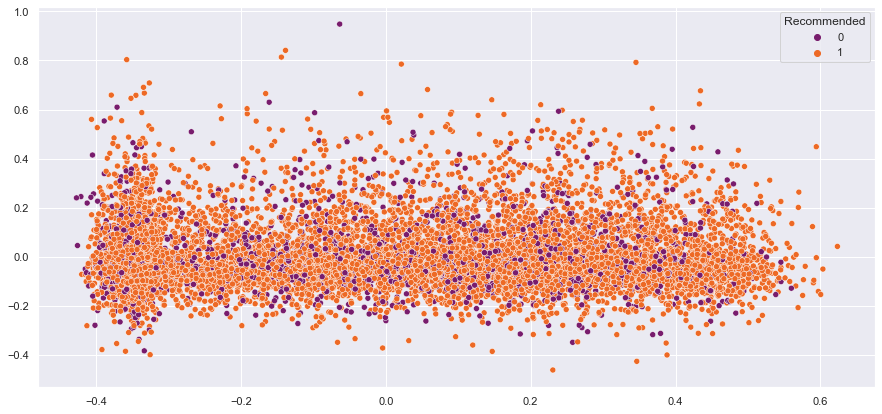

In [83]:
plt.figure(figsize=(15,7))
sns.scatterplot(x=X_train_scaled_pca[:, 0], 
                y=X_train_scaled_pca[:, 1], 
                hue=y_train, 
                sizes=100,
                palette="inferno") 

In [84]:
X_train_scaled = scipy.sparse.csr_matrix(X_train_scaled)
X_test_scaled = scipy.sparse.csr_matrix(X_test_scaled)

X_train = scipy.sparse.csr_matrix(X_train.values)
X_test = scipy.sparse.csr_matrix(X_test.values)
X_test

<4945x7280 sparse matrix of type '<class 'numpy.float64'>'
	with 71934 stored elements in Compressed Sparse Row format>

In [85]:
def report(y_true, y_pred, labels):
    cm = pd.DataFrame(confusion_matrix(y_true=y_true, y_pred=y_pred), 
                                        index=labels, columns=labels)
    rep = classification_report(y_true=y_true, y_pred=y_pred)
    return (f'Confusion Matrix:\n{cm}\n\nClassification Report:\n{rep}')

In [86]:
svc_model = SVC(C=1.0, 
             kernel='linear',
             class_weight='balanced', 
             probability=True,
             random_state=111)
svc_model.fit(X_train_scaled, y_train)

SVC(class_weight='balanced', kernel='linear', probability=True,
    random_state=111)

In [87]:
test_predictions = svc_model.predict(X_test_scaled)
print(report(y_test, test_predictions, svc_model.classes_ ))

Confusion Matrix:
     0     1
0  517   380
1  995  3053

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.58      0.43       897
           1       0.89      0.75      0.82      4048

    accuracy                           0.72      4945
   macro avg       0.62      0.67      0.62      4945
weighted avg       0.79      0.72      0.75      4945



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

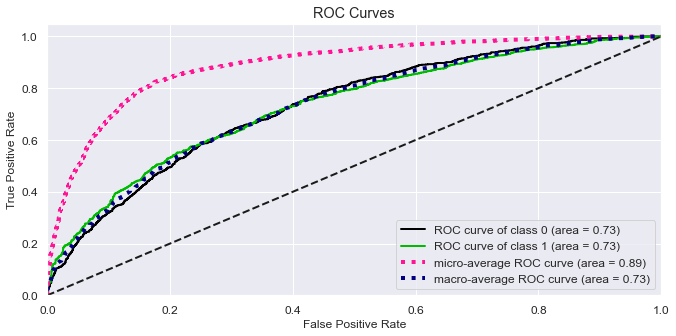

In [88]:
skplt.metrics.plot_roc(y_test, svc_model.predict_proba(X_test_scaled)) 

In [89]:
lr_model = LogisticRegression(class_weight='balanced', 
                              random_state=111, 
                              solver='lbfgs',
                              C=1.0)

gs_lr_model = GridSearchCV(lr_model, 
                           param_grid={'C': [0.01, 0.1, 0.5, 1.0, 5.0]}, 
                           cv=5, 
                           scoring='roc_auc')

gs_lr_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=111),
             param_grid={'C': [0.01, 0.1, 0.5, 1.0, 5.0]}, scoring='roc_auc')

In [90]:
gs_lr_model.best_params_

{'C': 0.1}

In [91]:
test_predictions = gs_lr_model.predict(X_test_scaled)
print(report(y_test, test_predictions, gs_lr_model.classes_ ))

Confusion Matrix:
      0     1
0   617   280
1  1100  2948

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.69      0.47       897
           1       0.91      0.73      0.81      4048

    accuracy                           0.72      4945
   macro avg       0.64      0.71      0.64      4945
weighted avg       0.81      0.72      0.75      4945



<AxesSubplot:title={'center':'ROC Curves - Logistic Regression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

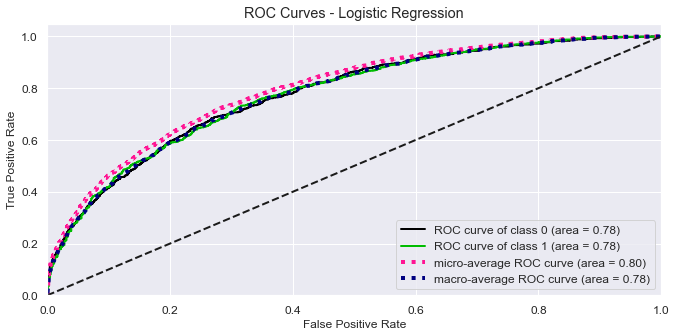

In [92]:
skplt.metrics.plot_roc(y_test, gs_lr_model.predict_proba(X_test_scaled),
                      title='ROC Curves - Logistic Regression') 

In [93]:
dt = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=555)

ada_model = AdaBoostClassifier(base_estimator=dt, learning_rate=0.001, n_estimators=1000, random_state=222)
ada_model.fit(X_train ,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=5,
                                                         random_state=555),
                   learning_rate=0.001, n_estimators=1000, random_state=222)

In [94]:
test_predictions = ada_model.predict(X_test)
print(report(y_test, test_predictions, ada_model.classes_ ))

Confusion Matrix:
     0     1
0  549   348
1  916  3132

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.61      0.46       897
           1       0.90      0.77      0.83      4048

    accuracy                           0.74      4945
   macro avg       0.64      0.69      0.65      4945
weighted avg       0.80      0.74      0.77      4945



<AxesSubplot:title={'center':'ROC Curves - AdaBoost'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

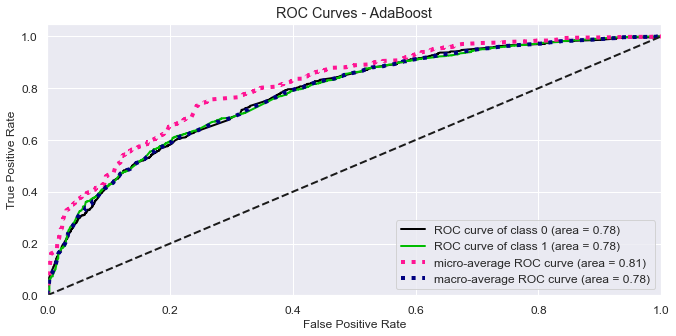

In [95]:
skplt.metrics.plot_roc(y_test, ada_model.predict_proba(X_test), 
                       title='ROC Curves - AdaBoost') 

In [96]:
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=5, 
                                  class_weight='balanced', random_state=3)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=1000,
                       random_state=3)

In [97]:
test_predictions = rf_model.predict(X_test)
print(report(y_test, test_predictions, rf_model.classes_ ))

Confusion Matrix:
     0     1
0  535   362
1  828  3220

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.60      0.47       897
           1       0.90      0.80      0.84      4048

    accuracy                           0.76      4945
   macro avg       0.65      0.70      0.66      4945
weighted avg       0.81      0.76      0.78      4945



<AxesSubplot:title={'center':'ROC Curves - Random Forest'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

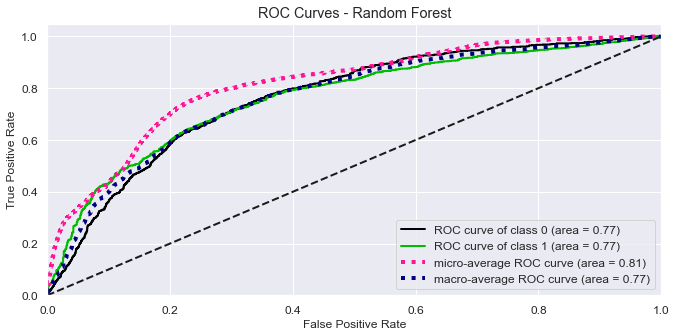

In [98]:
skplt.metrics.plot_roc(y_test, rf_model.predict_proba(X_test), 
                       title='ROC Curves - Random Forest') 

In [99]:
my_list = list(zip(rf_model.feature_importances_ ,X.columns))
my_list.sort(key=lambda tup: tup[0],reverse=True)
my_list[:7]

[(0.06289930853779568, 'Polarity'),
 (0.055156390323375167, 'count_exc'),
 (0.021386684929165435, 'Review_length'),
 (0.011894601207282649, 3465),
 (0.009851650847294266, 2416),
 (0.009284936953421651, 2546),
 (0.009115202968963206, 3522)]

In [100]:
bow_list = [i for i in bow_transformer.vocabulary_.items()]

for i in my_list:
    for j in bow_list:
        if i[1] == j[1] and i[0]> 0.005:
            print(f'Importance: {i[0]:.4f}   Word num: {i[1]}   Word:  { j[0]}')

Importance: 0.0119   Word num: 3465   Word:  look
Importance: 0.0099   Word num: 2416   Word:  full
Importance: 0.0093   Word num: 2546   Word:  good
Importance: 0.0091   Word num: 3522   Word:  low
Importance: 0.0081   Word num: 2042   Word:  extra
Importance: 0.0068   Word num: 2364   Word:  found
Importance: 0.0059   Word num: 3212   Word:  knew
Importance: 0.0055   Word num: 4832   Word:  receiv
Importance: 0.0055   Word num: 1605   Word:  differ
Importance: 0.0054   Word num: 763   Word:  bright
Importance: 0.0051   Word num: 5098   Word:  run
Importance: 0.0051   Word num: 873   Word:  buy
Importance: 0.0051   Word num: 2197   Word:  fit
Importance: 0.0050   Word num: 3438   Word:  long


In [101]:
probs = rf_model.predict_proba(X_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, probs[:,1])

Text(0, 0.5, 'TPR')

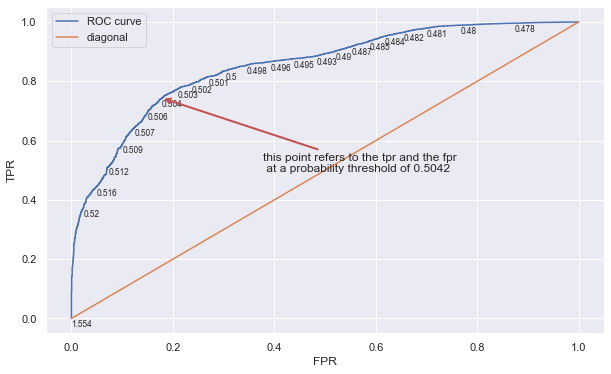

In [102]:
#Train
plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, '-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::100], tpr[::100], thresholds[::100]):
    plt.annotate(np.round(txt,3), (x, y-0.03), fontsize='x-small')
rnd_idx = 700
plt.annotate('this point refers to the tpr and the fpr\n at a probability threshold of {}'\
             .format(np.round(thresholds[rnd_idx], 4)), 
             xy=(fpr[rnd_idx], tpr[rnd_idx]), xytext=(fpr[rnd_idx]+0.2, tpr[rnd_idx]-0.25),
             arrowprops=dict(facecolor='black', lw=2, arrowstyle='->',color='r'),)
plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")

In [103]:
probs = rf_model.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:,1])

Text(0, 0.5, 'TPR')

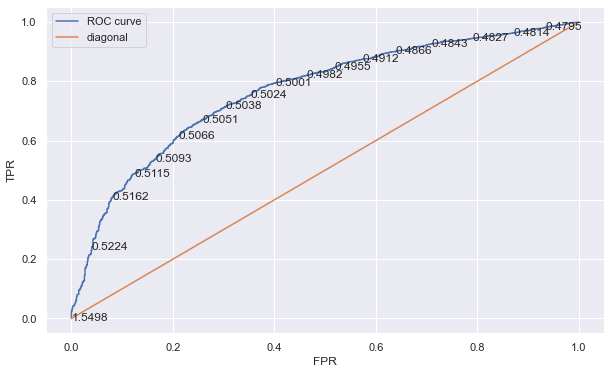

In [104]:
#Test
plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, '-', label="ROC curve")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
for x, y, txt in zip(fpr[::70], tpr[::70], thresholds[::70]):
    plt.annotate(np.round(txt,4), (x, y-0.01))

plt.legend(loc="upper left")
plt.xlabel("FPR")
plt.ylabel("TPR")

# 2

In [5]:
import warnings
warnings.filterwarnings('ignore')
!pip install git+https://github.com/rwalk/gsdmm.git
!pip install gensim

import numpy as np 
import pandas as pd

import sys
sys.path.append('../input/gsdmm-short-text-clustering')
from gsdmm import MovieGroupProcess

from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
from gensim.utils import simple_preprocess
import gensim, spacy
from gensim.models.ldamulticore import LdaMulticore
import re


from gensim.models import Phrases
from gensim.models.phrases import Phraser

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

  Cloning https://github.com/rwalk/gsdmm.git to c:\users\glori\appdata\local\temp\pip-req-build-2eckha3n
  Resolved https://github.com/rwalk/gsdmm.git to commit 4ad1b6b6976743681ee4976b4573463d359214ee


  Running command git clone -q https://github.com/rwalk/gsdmm.git 'C:\Users\glori\AppData\Local\Temp\pip-req-build-2eckha3n'


  Using cached gensim-4.2.0-cp39-cp39-win_amd64.whl (23.9 MB)
  Using cached smart_open-6.2.0-py3-none-any.whl (58 kB)
  Using cached Cython-0.29.28-py2.py3-none-any.whl (983 kB)
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.24
    Uninstalling Cython-0.29.24:


ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'c:\\programdata\\anaconda3\\lib\\site-packages\\__pycache__\\cython.cpython-39.pyc'
Consider using the `--user` option or check the permissions.



ModuleNotFoundError: No module named 'gensim'

In [6]:
data = pd.read_csv('tripadvisor_hotel_reviews.csv', encoding='utf-8')
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [7]:
data['length'] = data.Review.apply(lambda row: len(row.split()))
print('Mean length: ', data['length'].mean())

Mean length:  104.37582353228247


<AxesSubplot:xlabel='length', ylabel='Density'>

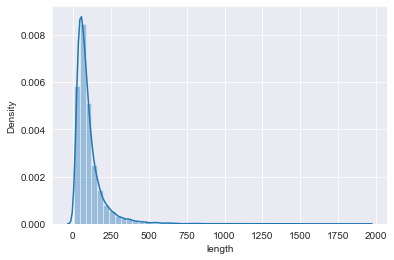

In [8]:
import seaborn as sns
sns.set_style(style="darkgrid")

sns.distplot(data['length'])

In [30]:
data['review_list'] = data.Review.values.tolist()

import re

# remove characters
data['review_list'] = [re.sub('\s+', ' ', sent) for sent in data['review_list']]
data['review_list'] = [re.sub("\'", "", sent) for sent in data['review_list']]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [31]:
# create N-grams
def make_n_grams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    bigrams_text = [bigram_mod[doc] for doc in texts]
    trigrams_text =  [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    return trigrams_text

In [18]:
import warnings
warnings.filterwarnings('ignore')

!pip install spacy

  Using cached spacy-3.4.3-cp39-cp39-win_amd64.whl (11.9 MB)


  Using cached wasabi-0.10.1-py3-none-any.whl (26 kB)
  Using cached spacy_loggers-1.0.3-py3-none-any.whl (9.3 kB)
  Using cached cymem-2.0.7-cp39-cp39-win_amd64.whl (30 kB)
  Using cached srsly-2.4.5-cp39-cp39-win_amd64.whl (481 kB)
  Using cached preshed-3.0.8-cp39-cp39-win_amd64.whl (96 kB)
  Using cached typer-0.7.0-py3-none-any.whl (38 kB)
  Using cached thinc-8.1.5-cp39-cp39-win_amd64.whl (1.3 MB)
  Using cached pydantic-1.10.2-cp39-cp39-win_amd64.whl (2.1 MB)
  Using cached pathy-0.8.1-py3-none-any.whl (46 kB)
  Using cached spacy_legacy-3.0.10-py2.py3-none-any.whl (21 kB)
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
  Using cached catalogue-2.0.8-py3-none-any.whl (17 kB)
  Using cached murmurhash-1.0.9-cp39-cp39-win_amd64.whl (18 kB)
  Using cached smart_open-5.2.1-py3-none-any.whl (58 kB)
  Using cached typing_extensions-4.4.0-py3-none-any.whl (26 kB)
  Using cached blis-0.7.9-cp39-cp39-win_amd64.whl (7.0 MB)
  Using cached confection-0.0.3-py3-none-any.whl (32 kB)

ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'c:\\programdata\\anaconda3\\lib\\site-packages\\__pycache__\\typing_extensions.cpython-39.pyc'
Consider using the `--user` option or check the permissions.



In [33]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# I use gensim stop-words and add me own stop-words, based on texts
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in gensim.parsing.preprocessing.STOPWORDS.union(set(['also', 'meanwhile','however', 'time', 
                                                                                                                           'hour', 'soon', 'day', 'book',
                                                                                                                           'there', 'hotel', 'room', 'leave',
                                                                                                                           'arrive',
                                                                                                                           'place', 'stay', 'staff', 'location',
                                                                                                                          'service', 'come', 'check',
                                                                                                                          'ask', 'lot', 'thing', 
                                                                                                                          'soooo', 'add', 'rarely',
                                                                                                                          'use', 'look', 'minute',
                                                                                                                          'bring', 'need', 'world',
                                                                                                                          'think', 'value', 'include']))] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [32]:
import gensim
from gensim.utils import simple_preprocess


tokens_reviews = list(sent_to_words(data['review_list']))
tokens_reviews = make_n_grams(tokens_reviews)

In [34]:
# do lemmatization keeping only noun, vb, adv
# because adj is not informative for reviews topic modeling
reviews_lemmatized = lemmatization(tokens_reviews, allowed_postags=['NOUN', 'VERB', 'ADV'])

# remove stop words after lemmatization
reviews_lemmatized = remove_stopwords(reviews_lemmatized)

In [92]:
np.random.seed(0)

In [93]:
mgp = MovieGroupProcess(K=6, alpha=0.01, beta=0.01, n_iters=30)

vocab = set(x for review in reviews_lemmatized for x in review)
n_terms = len(vocab)
model = mgp.fit(reviews_lemmatized, n_terms)

In stage 0: transferred 15831 clusters with 6 clusters populated
In stage 1: transferred 8795 clusters with 6 clusters populated
In stage 2: transferred 5403 clusters with 6 clusters populated
In stage 3: transferred 4504 clusters with 6 clusters populated
In stage 4: transferred 3759 clusters with 6 clusters populated
In stage 5: transferred 3175 clusters with 6 clusters populated
In stage 6: transferred 2891 clusters with 6 clusters populated
In stage 7: transferred 2710 clusters with 6 clusters populated
In stage 8: transferred 2667 clusters with 6 clusters populated
In stage 9: transferred 2537 clusters with 6 clusters populated
In stage 10: transferred 2458 clusters with 6 clusters populated
In stage 11: transferred 2400 clusters with 6 clusters populated
In stage 12: transferred 2300 clusters with 6 clusters populated
In stage 13: transferred 2261 clusters with 6 clusters populated
In stage 14: transferred 2261 clusters with 6 clusters populated
In stage 15: transferred 2139 clus

In [94]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster,sort_dicts))

In [95]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('\nMost important clusters (by number of docs inside):', top_index)
# show the top 5 words in term frequency for each cluster 
top_words(mgp.cluster_word_distribution, top_index, 10)

Number of documents per topic : [2978 1826 2121 5285 1971 6310]

Most important clusters (by number of docs inside): [5 3 0 2 4 1]

Cluster 5 : [('resort', 8841), ('beach', 8787), ('food', 7415), ('pool', 6648), ('restaurant', 5644), ('night', 5529), ('people', 4999), ('want', 3889), ('drink', 3592), ('bar', 3458)]

Cluster 3 : [('breakfast', 3566), ('night', 3354), ('walk', 2420), ('bathroom', 2061), ('bed', 2009), ('restaurant', 1801), ('area', 1693), ('view', 1638), ('floor', 1496), ('city', 1483)]

Cluster 0 : [('night', 1797), ('breakfast', 1271), ('walk', 1263), ('bed', 1141), ('restaurant', 1084), ('area', 1020), ('view', 951), ('price', 933), ('bathroom', 744), ('floor', 735)]

Cluster 2 : [('breakfast', 1343), ('walk', 1098), ('night', 995), ('restaurant', 718), ('florence', 717), ('recommend', 589), ('bathroom', 531), ('city', 527), ('area', 462), ('return', 451)]

Cluster 4 : [('night', 827), ('breakfast', 669), ('view', 668), ('restaurant', 571), ('bed', 499), ('experience'

In [96]:
topic_dict = {}
topic_names = ['type 1',
               'type 2',
               'type 3',
               'type 4',
               'type 5',
               'type 6',
              ]
for i, topic_num in enumerate(top_index):
    topic_dict[topic_num]=topic_names[i] 

In [97]:
def create_topics_dataframe(data_text=data.Review,  mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=reviews_lemmatized):
    result = pd.DataFrame(columns=['Text', 'Topic', 'Rating', 'Lemma-text'])
    for i, text in enumerate(data_text):
        result.at[i, 'Text'] = text
        result.at[i, 'Rating'] = data.Rating[i]
        result.at[i, 'Lemma-text'] = lemma_text[i]
        prob = mgp.choose_best_label(reviews_lemmatized[i])
        if prob[1] >= threshold:
            result.at[i, 'Topic'] = topic_dict[prob[0]]
        else:
            result.at[i, 'Topic'] = 'Other'
    return result

In [98]:
result = create_topics_dataframe(data_text=data.Review, mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=reviews_lemmatized)
result.head(5)

,Text,Topic,Rating,Lemma-text
0,nice hotel expensive parking got good deal sta...,type 6,4,"[parking, deal, anniversary, evening, advice, ..."
1,ok nothing special charge diamond member hilto...,Other,2,"[charge, diamond_member, decide, chain, shoot,..."
2,nice rooms not 4* experience hotel monaco seat...,type 1,3,"[experience, positive, bathroom, suite, bed, h..."
3,"unique, great stay, wonderful time hotel monac...",type 3,5,"[stroll, downtown, shopping, area, pet, sign, ..."
4,"great stay great stay, went seahawk game aweso...",type 1,5,"[game, downfall, view, building, complain, web..."


In [99]:
import plotly.express as px

fig = px.pie(result, names='Topic',  title='Topics', color_discrete_sequence=px.colors.sequential.Burg)
fig.show()

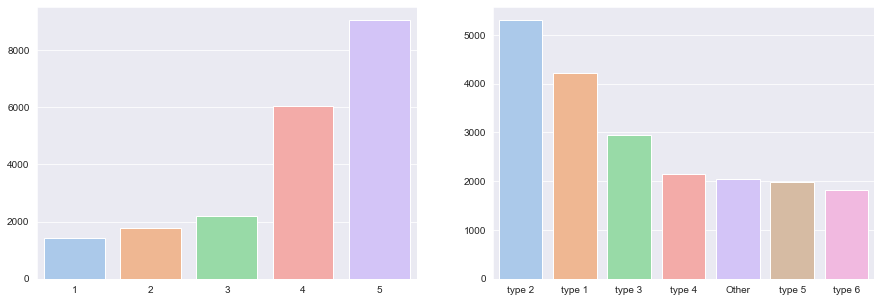

In [100]:
import matplotlib.pyplot as plt

rating_counts = result.Rating.value_counts()
types_counts = result.Topic.value_counts()
fig, ax = plt.subplots(1, 2, figsize=(15,5))
rating = sns.barplot(x = rating_counts.index, y = rating_counts.values, palette="pastel", ax=ax[0])
types = sns.barplot(x = types_counts.index, y = types_counts.values, palette="pastel", ax=ax[1])

In [101]:
fig = px.sunburst(result, path=['Topic', 'Rating'], title='Topics and ratings', color_discrete_sequence=px.colors.sequential.Burg)
fig.show()

In [53]:
result['len'] = result.Text.apply(lambda row: len(row.split()))
result.head()

,Text,Topic,Rating,Lemma-text,len
0,nice hotel expensive parking got good deal sta...,type 4,4,"[parking, deal, anniversary, evening, advice, ...",87
1,ok nothing special charge diamond member hilto...,Other,2,"[charge, diamond_member, decide, chain, shoot,...",250
2,nice rooms not 4* experience hotel monaco seat...,type 1,3,"[experience, positive, bathroom, suite, bed, h...",217
3,"unique, great stay, wonderful time hotel monac...",type 3,5,"[stroll, downtown, shopping, area, pet, sign, ...",89
4,"great stay great stay, went seahawk game aweso...",type 1,5,"[game, downfall, view, building, complain, web...",191


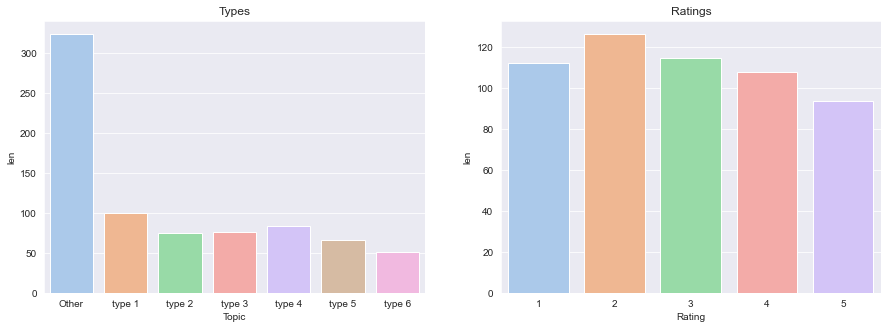

In [54]:
types_len = result.groupby(by=['Topic']).mean()
rating_len = result.groupby(by=['Rating']).mean()

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('Types')
ax[1].set_title('Ratings')
types = sns.barplot(x = types_len.index, y = types_len['len'], palette="pastel",  ax=ax[0])
rating = sns.barplot(x = rating_len.index, y = rating_len['len'], palette="pastel", ax=ax[1])

In [55]:
result.Rating = pd.to_numeric(result.Rating)

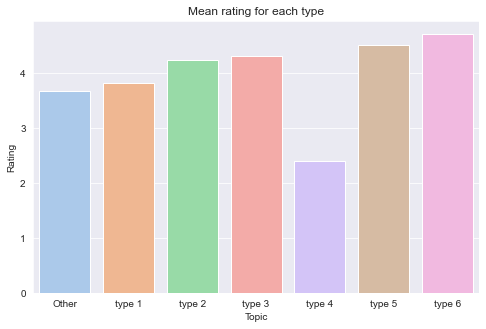

In [56]:
types_rating = result.drop('len', axis='columns').groupby(by=['Topic']).mean()

fig, ax = plt.subplots(figsize=(8,5))
ax.set_title('Mean rating for each type')
types = sns.barplot(x = types_rating.index, y = types_rating.Rating, palette="pastel")

In [102]:
result['Lemma_text'] = result['Lemma-text'].apply(lambda row: ' '.join(row))

In [103]:
result = result.drop('Lemma-text', axis=1)

In [104]:
from wordcloud import WordCloud 
def create_WordCloud(data, title=None):
    wordcloud = WordCloud(width = 500, height = 500,
                          background_color ='white',
                          min_font_size = 15
                         ).generate(" ".join(data.values))
                      
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=20)
    plt.show() 

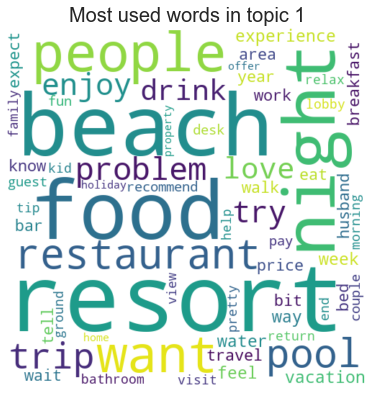

In [105]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 1'], title="Most used words in topic 1")

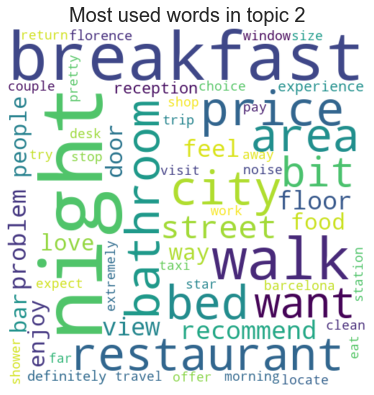

In [61]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 2'], title="Most used words in topic 2")

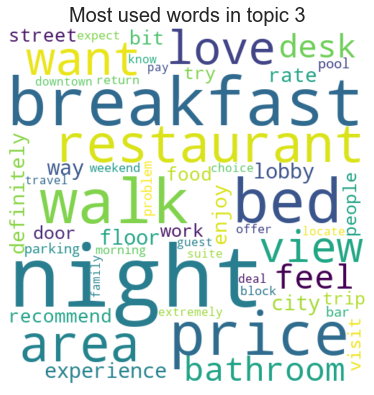

In [62]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 3'], title="Most used words in topic 3")

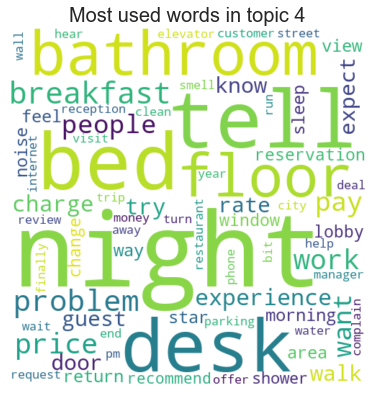

In [63]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 4'], title="Most used words in topic 4")

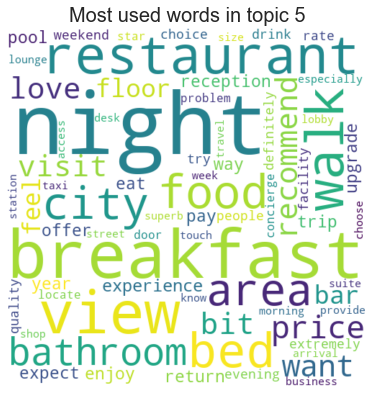

In [64]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 5'], title="Most used words in topic 5")

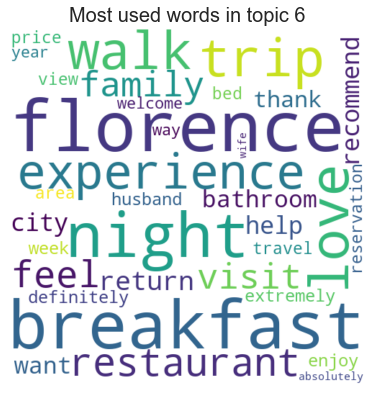

In [65]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'type 6'], title="Most used words in topic 6")

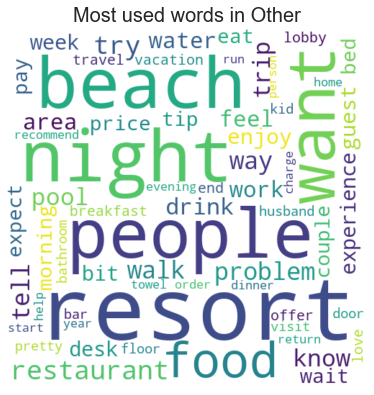

In [66]:
create_WordCloud(result['Lemma_text'].loc[result.Topic == 'Other'], title="Most used words in Other")

In [106]:
from gensim import corpora
id2word = corpora.Dictionary(reviews_lemmatized)
texts = reviews_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [107]:
from gensim import models

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [108]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

def calc_coherence_values(dictionary, corpus, texts, limit = 12, start = 1, step = 1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,id2word = dictionary, num_topics = num_topics, alpha=.1, eta=0.1, random_state = 42)
        model_list.append(model)
        print('model created')
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = calc_coherence_values(dictionary = id2word, corpus = corpus_tfidf, texts = texts, start = 20, limit = 30, step = 2)

model created
0.31955594214985983
model created
0.31927718174424063
model created
0.3172096431107219
model created
0.3137323082455839
model created
0.32054067422170807


In [109]:
import matplotlib.pyplot as plt

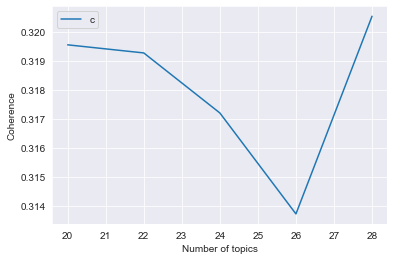

In [110]:
limit, start, step = 30, 20, 2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [78]:
index = coherence_values.index(max(coherence_values))
model_list[index].show_topics()

[(13,
  '0.003*"resort" + 0.003*"night" + 0.003*"restaurant" + 0.002*"breakfast" + 0.002*"walk" + 0.002*"recommend" + 0.002*"beach" + 0.002*"area" + 0.002*"pool" + 0.002*"price"'),
 (4,
  '0.002*"beach" + 0.002*"resort" + 0.002*"breakfast" + 0.002*"area" + 0.002*"walk" + 0.002*"food" + 0.002*"night" + 0.002*"bed" + 0.002*"pool" + 0.002*"want"'),
 (21,
  '0.003*"resort" + 0.003*"beach" + 0.002*"night" + 0.002*"walk" + 0.002*"restaurant" + 0.002*"pool" + 0.002*"area" + 0.002*"food" + 0.002*"breakfast" + 0.002*"bed"'),
 (27,
  '0.002*"view" + 0.002*"night" + 0.002*"walk" + 0.002*"city" + 0.002*"breakfast" + 0.002*"restaurant" + 0.002*"pool" + 0.002*"bed" + 0.002*"beach" + 0.002*"price"'),
 (9,
  '0.002*"beach" + 0.002*"food" + 0.002*"restaurant" + 0.002*"resort" + 0.002*"night" + 0.002*"pay" + 0.002*"pool" + 0.002*"bed" + 0.002*"breakfast" + 0.002*"walk"'),
 (12,
  '0.002*"walk" + 0.002*"breakfast" + 0.002*"beach" + 0.002*"night" + 0.002*"pool" + 0.002*"view" + 0.002*"restaurant" + 0.002*

In [82]:
!pip install pyLDAvis
import pyLDAvis.gensim_models

lda_display = pyLDAvis.gensim_models.prepare(model_list[index], corpus_tfidf, id2word, sort_topics = False)
pyLDAvis.display(lda_display)

In [83]:
def format_topics_sentences(lda_model, corpus, data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(lda_model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [84]:
df_topic_sents_keywords = format_topics_sentences(model_list[index], corpus_tfidf, texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,21.0,0.6552,"resort, beach, night, walk, restaurant, pool, ...","[parking, deal, anniversary, evening, advice, ..."
1,1,0.0,0.4911,"pool, beach, resort, food, night, area, bed, b...","[charge, diamond_member, decide, chain, shoot,..."
2,2,21.0,0.3915,"resort, beach, night, walk, restaurant, pool, ...","[experience, positive, bathroom, suite, bed, h..."
3,3,27.0,0.6623,"view, night, walk, city, breakfast, restaurant...","[stroll, downtown, shopping, area, pet, sign, ..."
4,4,9.0,0.5260,"beach, food, restaurant, resort, night, pay, p...","[game, downfall, view, building, complain, web..."
5,5,26.0,0.4556,"breakfast, resort, night, walk, price, beach, ...","[husband, weekend, attend, friend, husband, ce..."
6,6,10.0,0.6903,"resort, breakfast, night, beach, pool, restaur...","[city, husband, spend, night, business, trip, ..."
7,7,23.0,0.6859,"night, breakfast, street, walk, area, view, re...","[housekeeping, quality, chock, feel, home, exp..."
8,8,11.0,0.6521,"breakfast, restaurant, night, bed, walk, view,...","[cruise, decorate, uniquely, remodel, build, c..."
9,9,26.0,0.5373,"breakfast, resort, night, walk, price, beach, ...","[reception, bed, particularly, like, reception..."


In [85]:
topic_counts = df_dominant_topic.Dominant_Topic.value_counts().sort_values(ascending=True)

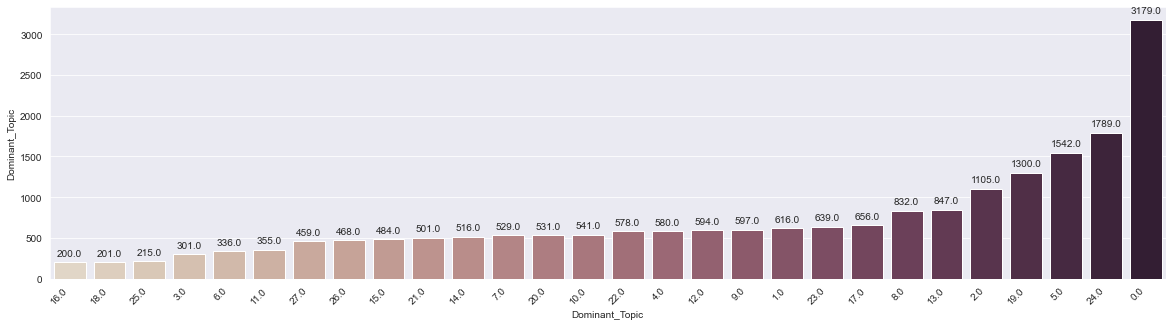

In [86]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x=topic_counts.index, y=topic_counts, data=topic_counts,  palette="ch:.25")
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
ax = ax.set_xticklabels(topic_counts.index, rotation = 45, ha="right")

In [87]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.head(24)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8524,"pool, beach, resort, food, night, area, bed, b...","[return, trip, reference, wife, age, group, re..."
1,1.0,0.7918,"breakfast, resort, night, view, food, love, be...","[couple, read, review, website, excite, mistak..."
2,2.0,0.8330,"resort, beach, food, pool, view, night, area, ...","[inclusive, week, arrangement, interline, trav..."
3,3.0,0.7300,"resort, beach, view, pool, food, night, walk, ...","[family, vacation, familyand, suppose, far, ex..."
4,4.0,0.7854,"beach, resort, breakfast, area, walk, food, ni...","[sirenis, night, weather, rain, rest, week, su..."
5,5.0,0.8017,"breakfast, night, area, restaurant, walk, view...","[pros_con, guesthouse, read, review, guesthous..."
6,6.0,0.7650,"price, night, resort, restaurant, breakfast, w...","[hyatt, review, gracia, por, todo, fitness, fa..."
7,7.0,0.7811,"resort, night, breakfast, restaurant, view, pr...","[absolutely, feel, write_review, resort, read,..."
8,8.0,0.7988,"night, beach, food, breakfast, bed, area, reso...","[travel, continent, resort, kind, wife, tour, ..."
9,9.0,0.7712,"beach, food, restaurant, resort, night, pay, p...","[vacation, toddler, husband, trip, resort, ton..."


In [88]:
from gensim.models import LsiModel

In [89]:
def calc_coherence_values_Lsi(dictionary, corpus, texts, limit, start = 2, step = 2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LsiModel(corpus=corpus, id2word = dictionary, num_topics = num_topics)
        print('model created')
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


model_list, coherence_values_Lsi = calc_coherence_values_Lsi(dictionary = id2word, corpus=corpus_tfidf, texts=texts, start = 2, limit = 30, step =2)

model created
0.41399489526044675
model created
0.40535055326371
model created
0.3740852189148906
model created
0.3756386549220688
model created
0.36357356448443706
model created
0.36447667735404526
model created
0.3481796818705521
model created
0.34105053767045246
model created
0.3411636612268637
model created
0.34228130107555443
model created
0.3336539072962398
model created
0.32834568125672625
model created
0.31865803979436724
model created
0.32406599948973014


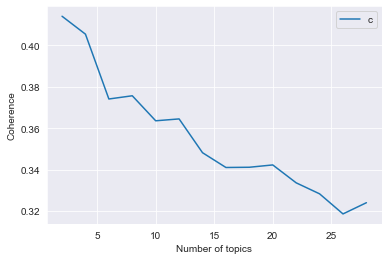

In [90]:
limit, start, step = 30, 2, 2
x = range(start, limit, step)
plt.plot(x, coherence_values_Lsi)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [91]:
index = coherence_values_Lsi.index(max(coherence_values_Lsi))
model_list[index].show_topics()

[(0,
  '0.196*"resort" + 0.173*"beach" + 0.139*"pool" + 0.136*"food" + 0.130*"restaurant" + 0.128*"night" + 0.118*"walk" + 0.114*"breakfast" + 0.114*"people" + 0.111*"area"'),
 (1,
  '-0.506*"resort" + -0.326*"beach" + -0.168*"pool" + 0.164*"city" + -0.158*"food" + 0.141*"breakfast" + -0.141*"vacation" + 0.132*"street" + 0.119*"bathroom" + 0.113*"walk"')]